In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa

In [2]:
def make_contig_df(contig_path, contig_name):
    """
    Make contig Dataframe from fasta file.
    """    
    f_handle = open(contig_path+'/'+contig_name, mode='r')
    contigs = SeqIO.parse(f_handle, 'fasta')
    contig_length = []
    contig_id =[]
    contig_GC = []
    assembly_id = []
    for x in contigs:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
        contig_GC.append(SeqUtils.GC(x.seq))
        assembly_id.append(p_and_a_ctg_file_name)
    s1 = pd.Series(contig_id, name='ID')
    s2 = pd.Series(contig_length, name='Length')
    s3 = pd.Series(contig_GC, name='%GC')
    s4 = pd.Series(assembly_id, name="Assembly")
    contig_df = pd.concat([s1, s2, s3, s4], axis=1)
    f_handle.close()
    return contig_df

In [3]:
#function to add another column for P and A_contig identification to dataframe
def P_and_A_identifier(df):
    """Method to add primary and alternative contig identifier rows to FC dataframes"""
    primary_list = []
    alternative_list = []
    return_df = df.iloc[:,:]
    for x in return_df['ID']:
        if "-" in list(x):
            primary_list.append(0)
            alternative_list.append(1)
        else:
            primary_list.append(1)
            alternative_list.append(0)
    return_df["P_contig"] = pd.Series(primary_list)
    return_df["A_contig"] = pd.Series(alternative_list)
    return_df = return_df.reset_index(drop=True)
    return return_df

In [53]:
#function that compares a seed with a result dataframe. It assesses if any initial IDs are missing from the result df
#and adds them with '0' in all columns to the result df
#ADD VALUE ERROR CHECK FOR EMPTY SEED_DF
def no_hit_df_extension(seed_df, result_df):
    """function that compares a seed with a result dataframe. 
    It assesses if any initial IDs are missing from the result df
    and adds them with '0' in all columns except the ID column.
    The first column in each dataframe needs to be labled 'ID'."""
    if len(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0]))) == 0:
        #test if there actually missing values
        return pd.DataFrame()
    else:
        no_hit_sr = pd.Series(list(set(seed_df.iloc[:,0])- set(result_df.iloc[:,0])))
        #make empty dataframe for no_hits
        empty = np.array([[0]*(len(result_df.columns)-1) for x in range(len(no_hit_sr))])
        no_hit_df = pd.DataFrame(empty, columns =result_df.columns[1:])
        no_hit_df[result_df.columns.tolist()[0]] = no_hit_sr
        no_hit_df = no_hit_df[result_df.columns]
        return no_hit_df

In [58]:
def coverage_df_generator(file_path, file_name, seq_type):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    coverage_df = coverage_df.sort_values(by=[coverage_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_df
#no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [6]:
def coverage_df_generator_all(file_path, file_name, seq_type, seed_df):
    """
    Function that pulls in bed file coverage file. 
    It labels the header and calculates the average coverage per segment.
    This also adds the IDs for which no hits have been reported.
    It returns a sorted df on the first ID column.
    """
    coverage_df = pd.read_csv(file_path+'/'+file_name, sep='\t', header=None)
    header_cov = ["ID-cov "+seq_type, "start "+seq_type, 'stop '+seq_type, "total hits "+seq_type]
    #rename the headear according bed file output
    rename = dict(zip(coverage_df.columns, header_cov))
    coverage_df.rename(columns=rename,inplace=True)
    #add another column for average coverage
    coverage_df["Average Coverage "+seq_type] = np.round(coverage_df['total hits '+seq_type]/(coverage_df['stop '+seq_type] -coverage_df['start '+seq_type]),3)
    #get no hit df, append and sort
    coverage_all_df = coverage_df.append(no_hit_df_extension(seed_df, coverage_df))
    coverage_all_df = coverage_all_df.sort_values(by=[coverage_all_df.columns.tolist()[0]]).reset_index(drop=True)
    return coverage_all_df
    #no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [7]:
def add_cov_to_summary(sum_df, cov_df):
    """add coverage dataframe last "Average Coverage" column to blast summary df"""
    sum_sorted_df = sum_df.sort_values(by=[sum_df.columns.tolist()[0]]).reset_index(drop=True)
    cov_sorted_df = cov_df.sort_values(by=[cov_df.columns.tolist()[0]]).reset_index(drop=True)
    if set(sum_sorted_df.iloc[:,0] == cov_sorted_df.iloc[:,0]):
        sum_sorted_df[cov_sorted_df.columns.tolist()[-1]] = cov_sorted_df.iloc[:, -1]
        return sum_sorted_df
    else: #this should be made to raise an error
        print('Dataframes do not have the same ids')

In [8]:
def tc_blast_df(blast_xml_path, blast_xml_file_name, tc_list):
    """
    Returns a df of xml blast hits of target contigs.
    """
    from Bio.Blast import NCBIXML
    f = open(blast_xml_path+'/'+blast_xml_file_name, mode='r')
    blast_rec = NCBIXML.parse(f)
    tc_blast_df = pd.DataFrame()
    for record in blast_rec:
        if record.query.split(' ')[0] in tc_list: #the split may needs to be updated based on query blastn file headers.
                                                    #THINK long initial headers not _sh_ format
            title_list = []
            query_contig = []
            title = record.query.split(' ')[0]
            for aln in record.alignments:
                title_list.append(aln.title)
                query_contig.append(title)
            result_df = pd.concat([pd.Series(query_contig, name='ID'), pd.Series(title_list, name='Blast Hit')], axis =1)
            tc_blast_df = tc_blast_df.append(result_df)
    f.close()
    tc_blast_df = tc_blast_df.reset_index(drop=True)
    return tc_blast_df

In [9]:
def print_first_5_blast_hits(blast_xml_df):
    """
    Does what is says in conjungtion with tc_blast_df.
    """
    #set count and read in first row
    count = 0
    previous = blast_xml_df.loc[0,'ID']
    #iterarte over each row and print the long blast_xml description until you reach #5
    for index,row in blast_xml_df.iterrows():
        if row['ID'] == previous:
            count += 1
            #print(count)
        if count < 6: 
            print(blast_xml_df.loc[index, 'ID'], '\t', blast_xml_df.loc[index, 'Blast Hit'].split('|')[4])
        if row['ID'] != previous:
            count = 0
        previous = row['ID']

In [10]:
#here pull in intial unpolished query file from Falcon p_and_a_ctg and generate a dataframe
p_and_a_ctg_path ='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/'
p_and_a_ctg_file_name = 'v4_1_p_and_a_ctg_sh.fa'
handle_1 = open(p_and_a_ctg_path+p_and_a_ctg_file_name)

In [11]:
#here enter your blast file you want to analyze in tabBS1 format
blast_tabBS1_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast/'
blast_tabBS1_handle = 'v4_1_p_and_a_sh.blast.local.tabBS1.nt'


In [12]:
#here enter in coverage files having the same IDs as seed file. This file has been produced by 'samtools bedcov'
cov_path='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/Quiver/run_wo_useccs_22/'
cov_file_name='v4_1_p_and_a_ctg_sh.999999999.bed'
seq_type='PacBio'

In [13]:
#here enter the illumina cov file
cov_path_2='/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/Quiver/run_wo_useccs_22/coverage_analysis/SRM'
cov_file_name_2='v4_1_p_and_a_sh.all_ete.sam.sorted.bam.contig.cov'
seq_type_2='Illumina_all'

In [14]:
#here enter file name extension to xml blast file output
blast_xml_path = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v4_1/blast'
blast_xml_file_name ='v4_1_p_and_a.blast.local.nt'

In [15]:
#make dataframe of initial query file p_and_a_ctg_df
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
contig_GC = []
assembly_id = []
for x in contigs:
    contig_id.append(x.id)
    contig_length.append(len(x.seq))
    contig_GC.append(SeqUtils.GC(x.seq))
    assembly_id.append(p_and_a_ctg_file_name)
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
s3 = pd.Series(contig_GC, name='%GC')
s4 = pd.Series(assembly_id, name="Assembly")
p_and_a_ctg_df = pd.concat([s1, s2, s3, s4], axis=1)
handle_1.close()

In [16]:
p_and_a_ctg_df = P_and_A_identifier(p_and_a_ctg_df)

In [17]:
#pull in blast tabBS1 file, and rename header according to tabBS1 format convention
blast_df = pd.read_csv(blast_tabBS1_path+blast_tabBS1_handle, sep='\t', header=None)
header = ['ID', 'sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'skingdoms']
rename = dict(zip(blast_df.columns, header))
blast_df.rename(columns=rename,inplace=True)

In [18]:
#transform the TaxiD into a kingdom (or closest possible identifier) and add this to the blast_df as 'Kingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
ncbi=  NCBITaxa()
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[4]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Kingdom'] = pd.Series(kingdom_list)

In [19]:
#transform the TaxiD into a Superkingdom (or closest possible identifier) and add this to the blast_df as 'sKingdom' column
#THIS MIGHT WANT TO BECOME A FUNCTION IN THE NEAR FUTURE
kingdom_list = []
for x in blast_df['staxids']:
    if ";" in list(x): #addresses the issue if one blast hit has multiple taxids
        x1 = x.split(";")[0]
        taxid_lineage = ncbi.get_lineage(x1)
    else:
        taxid_lineage = ncbi.get_lineage(x)
    if len(taxid_lineage) < 5: #addresses the issue if their is no kingdom id. simply pick the next up
        kingdom = ncbi.get_taxid_translator([taxid_lineage[-1]])
    else:
        kingdom = ncbi.get_taxid_translator([taxid_lineage[2]])
    kingdom_list.append(kingdom[list(kingdom)[0]])
blast_df['Superkingdom'] = pd.Series(kingdom_list)

In [20]:
bast_df = P_and_A_identifier(blast_df)

In [21]:
no_blast_hit_df = no_hit_df_extension(p_and_a_ctg_df, blast_df)

In [22]:
#append original blast_df with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
blast_all_df = blast_df.append(no_blast_hit_df)
blast_all_sorted_df  = blast_all_df.sort_values(by=['ID'])[list(no_blast_hit_df.columns)].reset_index(drop=True)
len(set(blast_all_df['ID'])) ==  len(p_and_a_ctg_df)

True

In [23]:
#get all Superkingdoms of the dataframe and all contigs
Superkingdoms = list(set(blast_all_sorted_df['Superkingdom']))
contigs = sorted(list(set(blast_all_sorted_df['ID'])))

In [24]:
#remove the '0' Superkingdom that was artificially generated by the no_hit_df
del Superkingdoms[Superkingdoms.index(0)]

In [25]:
#create a df summarizing all blast hits for each contig at the Superkingdom level
list_of_summary_series =[]
overall_count = 0
for king in Superkingdoms:
    king_list = []
    ID_list = []
    for Series in blast_all_sorted_df.groupby('ID')['Superkingdom']:
        for x in Series[1:]: #is the list of ['Superkingdom'] for each 'ID'
            count = 0
            for hit in x:
                overall_count += 1
                if hit == king:
                    count += 1
            king_list.append(count)
            ID_list.append(Series[0])
    list_of_summary_series.append(pd.Series(king_list, name=king))
list_of_summary_series.append(pd.Series(ID_list,name='ID'))
blast_hit_summary_df = pd.concat(list_of_summary_series, axis=1)
#create a 'Total Blast Hits' column
blast_hit_summary_df['Total Blast Hits'] = blast_hit_summary_df[blast_hit_summary_df.columns[0]]*0
for x in range(0, (len(Superkingdoms))):
    blast_hit_summary_df['Total Blast Hits'] = blast_hit_summary_df['Total Blast Hits'] + blast_hit_summary_df[list(blast_hit_summary_df.columns)[x]]  
#create %Eukaryota columns
blast_hit_summary_df['%Eukaryota'] = np.round(blast_hit_summary_df['Eukaryota']/blast_hit_summary_df['Total Blast Hits']*100, 2)
blast_hit_summary_df = blast_hit_summary_df.fillna(0)
#quick test if all went correct
len(blast_hit_summary_df['Total Blast Hits'])- len(blast_all_sorted_df.groupby('ID')['Superkingdom'])

0

In [26]:
#rename the ID header to ID-blast so it is easier to delete later
new_header = blast_hit_summary_df.columns.tolist()
new_header[new_header.index('ID')] = 'ID-blast'
old_header = blast_hit_summary_df.columns.tolist()
header_dict = dict(zip(old_header, new_header))
blast_hit_summary_df.rename( columns= header_dict,inplace=True)

In [27]:
p_and_a_ctg_sorted_df = p_and_a_ctg_df.sort_values(by='ID').reset_index(drop=True)

In [28]:
#add the summary_df to the seed_df
p_and_a_ctg_blast_df = pd.concat([p_and_a_ctg_sorted_df, blast_hit_summary_df.sort_values(by='ID-blast')], axis =1)

In [29]:
#quick test if all went alright
set(p_and_a_ctg_blast_df.loc[:,'ID'] == p_and_a_ctg_blast_df.loc[:,'ID-blast'])
p_and_a_ctg_blast_df[p_and_a_ctg_blast_df['Total Blast Hits'] == 0].count()

ID                       84
Length                   84
%GC                      84
Assembly                 84
P_contig                 84
A_contig                 84
Eukaryota                84
Archaea                  84
synthetic construct      84
Bacteria                 84
environmental samples    84
ID-blast                 84
Total Blast Hits         84
%Eukaryota               84
dtype: int64

In [30]:
#delete the 'ID-blast' column
del p_and_a_ctg_blast_df['ID-blast']

In [31]:
p_and_a_ctg_blast_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Eukaryota,Archaea,synthetic construct,Bacteria,environmental samples,Total Blast Hits,%Eukaryota
0,000000F,5374253,44.246261,v4_1_p_and_a_ctg_sh.fa,1,0,995,0,0,0,1,996,99.9
1,000000F-001-01,89692,43.236855,v4_1_p_and_a_ctg_sh.fa,0,1,3,0,0,0,0,3,100.0
2,000000F-003-01,74018,43.061147,v4_1_p_and_a_ctg_sh.fa,0,1,17,0,0,0,0,17,100.0
3,000000F-004-01,77348,42.430315,v4_1_p_and_a_ctg_sh.fa,0,1,17,0,0,0,0,17,100.0
4,000000F-005-01,162191,44.186176,v4_1_p_and_a_ctg_sh.fa,0,1,32,0,0,0,0,32,100.0


In [32]:
#add another column to the data frame that IDs the primary associated contig
primary_ID = []
for x in p_and_a_ctg_blast_df['ID']:
    if "-" in list(x):
        primary_ID.append(x[0:7])
    else:
        primary_ID.append(x)
p_and_a_ctg_blast_df["P_ID"] = pd.Series(primary_ID)

In [33]:
#safe the dataframe in cwd
p_and_a_ctg_blast_df.to_csv(blast_tabBS1_handle+'.blast_summary.csv', sep='\t', encoding='utf-8')

In [35]:
cov_all_df = coverage_df_generator_all(cov_path, cov_file_name, 'PacBio', p_and_a_ctg_df)

In [36]:
#append original blast_df with empty dataframe, sort by ID. 
#check for correct length between p_and_a_ctg_df and blast_all_df
cov_all_df = coverage_df_generator_all(cov_path, cov_file_name, 'PacBio', p_and_a_ctg_df)
cov_all_sorted_df  = cov_all_df.sort_values(by=[cov_all_df.columns.tolist()[0]]).reset_index(drop=True)
len(set(cov_all_sorted_df.iloc[:,0])) ==  len(p_and_a_ctg_df)

True

In [37]:
#add the PacBio coverage
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_df, cov_all_sorted_df)

In [64]:
#add the Illumina coverage
cov_contig_illumina = coverage_df_generator_all(cov_path_2, cov_file_name_2, seq_type_2, p_and_a_ctg_df)
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [39]:
#safe the dataframe in cwd
p_and_a_ctg_blast_cov_df.to_csv(p_and_a_ctg_file_name+'.blast_cov_summary.csv', sep='\t', encoding='utf-8')

In [40]:
#example for getting blast results of interesting contigs
Eu_smaller_70_list = p_and_a_ctg_blast_cov_df[(p_and_a_ctg_blast_cov_df['%Eukaryota']<70)]['ID'].tolist()
Eu_smaller_70_blast_df = tc_blast_df(blast_xml_path, blast_xml_file_name, Eu_smaller_70_list)

In [41]:
#example to print the first 5 blast hits of each of those interesting contigs
print_first_5_blast_hits(Eu_smaller_70_blast_df)

000200F 	  Phakopsora pachyrhizi clone JGIAFNA-73C6, complete sequence
000200F 	  Melampsora larici-populina 98AG31 hypothetical protein (MELLADRAFT_48126), partial mRNA
000200F 	  Myroides odoratimimus strain PR63039, complete genome
000200F 	  Nonlabens dokdonensis DSW-6, complete genome
000200F 	  Lichtheimia ramosa genome assembly Lramosa_hybrid_454_Illumina, scaffold SCAF2
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_16280), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 nonsense-mediated mRNA decay protein 3 (PGTG_03805), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein, variant (PGTG_15611), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 hypothetical protein (PGTG_15611), mRNA
000006F-001-01 	  Puccinia graminis f. sp. tritici CRL 75-36-700-3 ATP synthase subunit alpha, mitochondrial (PGTG_15605), mRNA
000006F-001-01 	  

(0, 60)

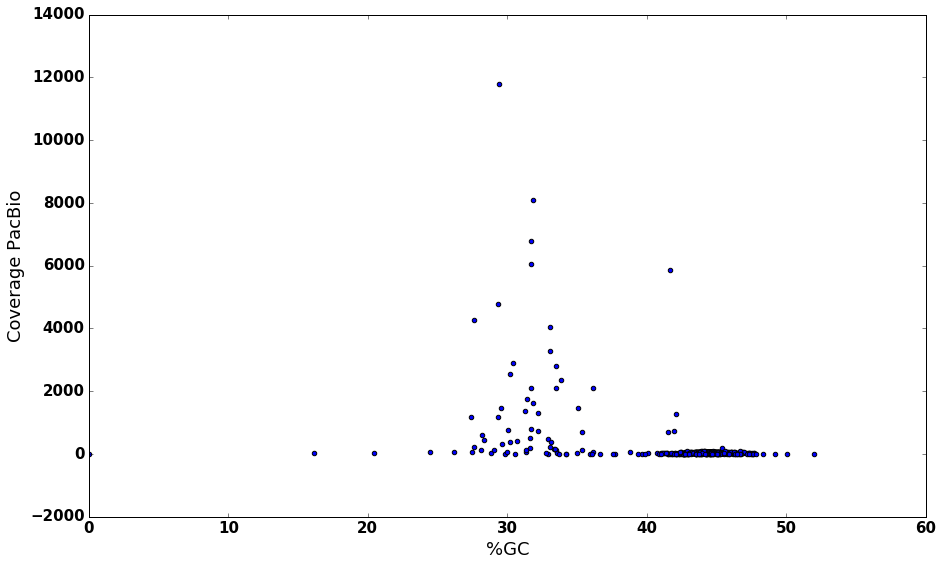

In [65]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Coverage PacBio', **label_config_y)

plt.xlim(0,60)

(0, 60)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


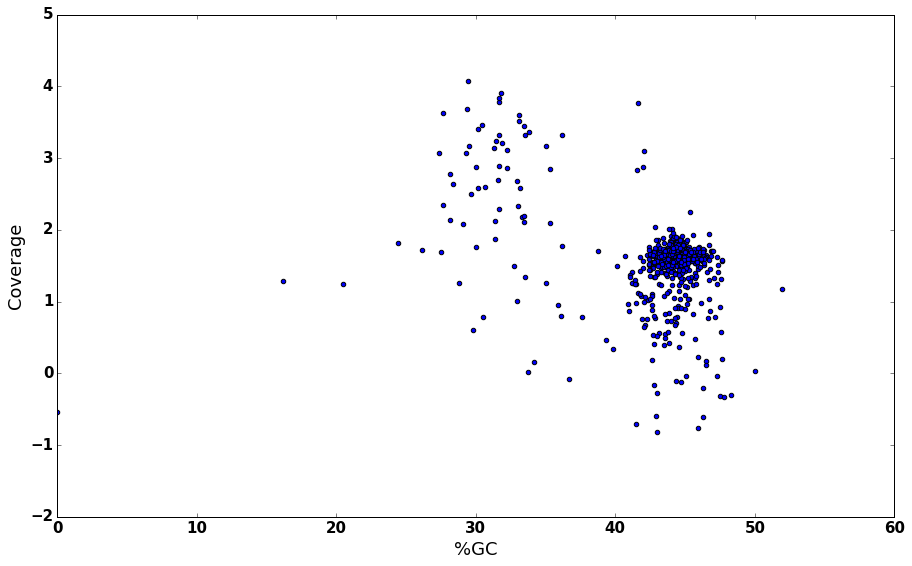

In [43]:
#some plotting examples
#e.g. %GC vs Average Coverage
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['%GC'], y=np.log10(p_and_a_ctg_blast_cov_df['Average Coverage PacBio']))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("%GC", **label_config_x)
plt.ylabel('Coverage', **label_config_y)

plt.xlim(0,60)

(-100, 14000)

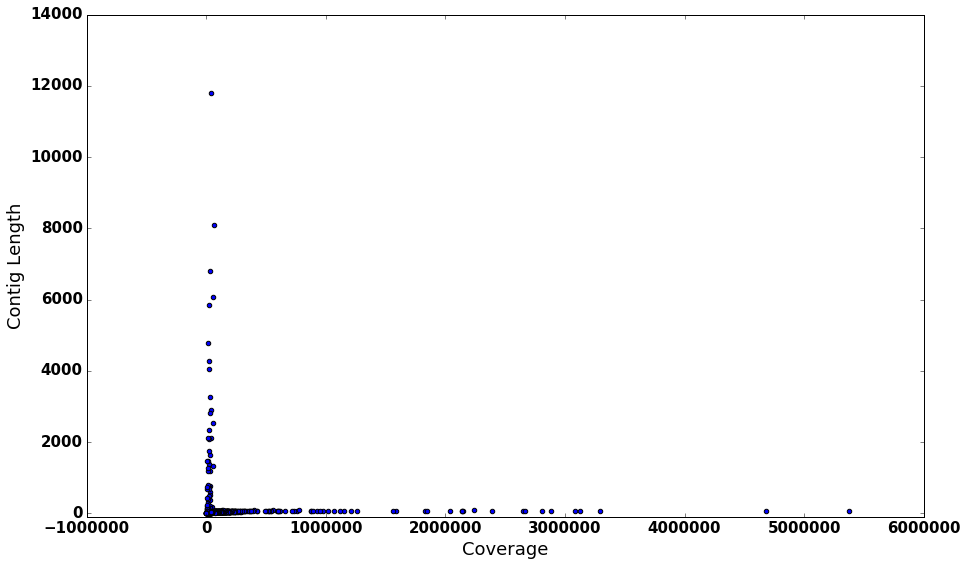

In [44]:
#contig_length vs Coverage
plt.figure(figsize=(15,9))
plt.scatter(y=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], x=p_and_a_ctg_blast_cov_df['Length'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Coverage", **label_config_x)
plt.ylabel('Contig Length', **label_config_y)
#plt.xlim(-10,400)
plt.ylim(-100,14000)

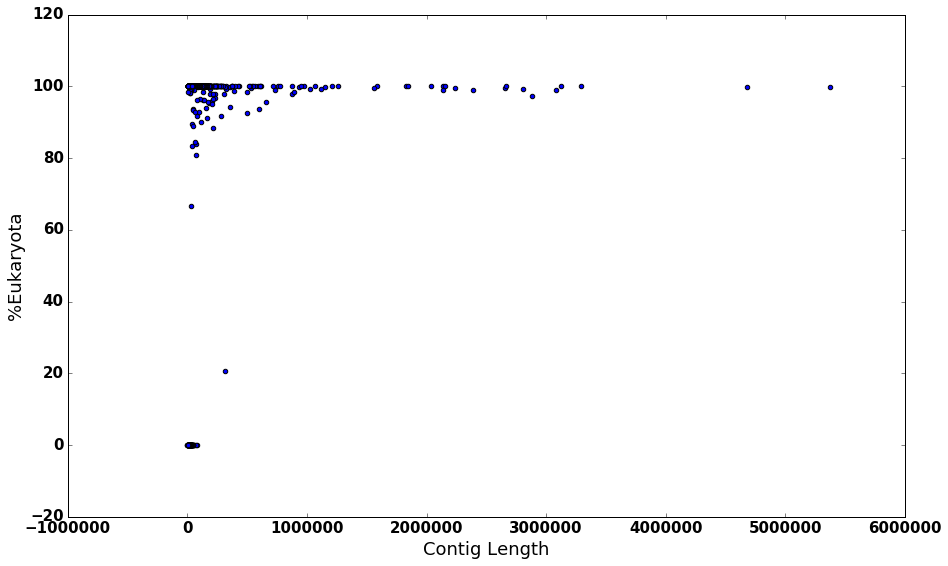

In [45]:
plt.figure(figsize=(15,9))
plt.scatter(x=p_and_a_ctg_blast_cov_df['Length'], y=p_and_a_ctg_blast_cov_df['%Eukaryota'])
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.xlabel("Contig Length", **label_config_x)
plt.ylabel('%Eukaryota', **label_config_y)
#plt.xlim(-10,400)
#plt.ylim(-100,1000000)

In [46]:
cov_contig_illumina = coverage_df_generator(cov_path_2, cov_file_name_2, seq_type_2)

In [47]:
cov_contig_illumina.head()

,ID-cov Illumina_all,start Illumina_all,stop Illumina_all,total hits Illumina_all,Average Coverage Illumina_all
0,000000F,0,5374253,564585167,105.054
1,000001F,0,4680286,499877592,106.805
2,000002F,0,3291248,309890395,94.156
3,000003F,0,3082276,342004407,110.958
4,000004F,0,3127203,272668471,87.192


In [48]:
p_and_a_ctg_blast_cov_df = add_cov_to_summary(p_and_a_ctg_blast_cov_df, cov_contig_illumina)

In [49]:
p_and_a_ctg_blast_cov_df.head()

,ID,Length,%GC,Assembly,P_contig,A_contig,Eukaryota,Archaea,synthetic construct,Bacteria,environmental samples,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina_all
0,000000F,5374253,44.246261,v4_1_p_and_a_ctg_sh.fa,1,0,995,0,0,0,1,996,99.9,000000F,70.129,105.054
1,000000F-001-01,89692,43.236855,v4_1_p_and_a_ctg_sh.fa,0,1,3,0,0,0,0,3,100.0,000000F,40.630,91.868
2,000000F-003-01,74018,43.061147,v4_1_p_and_a_ctg_sh.fa,0,1,17,0,0,0,0,17,100.0,000000F,41.174,79.749
3,000000F-004-01,77348,42.430315,v4_1_p_and_a_ctg_sh.fa,0,1,17,0,0,0,0,17,100.0,000000F,58.217,92.195
4,000000F-005-01,162191,44.186176,v4_1_p_and_a_ctg_sh.fa,0,1,32,0,0,0,0,32,100.0,000000F,45.313,73.464


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


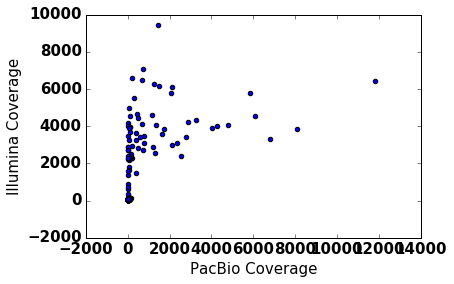

In [50]:
plt.scatter(x=p_and_a_ctg_blast_cov_df['Average Coverage PacBio'], y=p_and_a_ctg_blast_cov_df['Average Coverage Illumina_all'])
plt.ylabel("Illumina Coverage")
plt.xlabel("PacBio Coverage")

In [51]:
p_and_a_ctg_blast_cov_df[p_and_a_ctg_blast_cov_df['Average Coverage PacBio'] < 1]

,ID,Length,%GC,Assembly,P_contig,A_contig,Eukaryota,Archaea,synthetic construct,Bacteria,environmental samples,Total Blast Hits,%Eukaryota,P_ID,Average Coverage PacBio,Average Coverage Illumina_all
33,000000F-042-01,1506,41.500664,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,0,0,0,000000F,0.198,86.222
191,000009F-002-01,734,37.738420,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,0,0,0,000009F,0.000,43.939
221,000011F-006-01,3530,48.300283,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,0,0,0,000011F,0.495,42.511
342,000025F-002-01,1852,42.602592,v4_1_p_and_a_ctg_sh.fa,0,1,0,0,0,0,0,0,0,000025F,0.000,42.999
381,000033F,8330,44.345738,v4_1_p_and_a_ctg_sh.fa,1,0,3,0,0,0,0,3,100,000033F,0.779,20.117
474,000059F,5749,39.676465,v4_1_p_and_a_ctg_sh.fa,1,0,0,0,0,0,0,0,0,000059F,0.000,27.171
697,000263F,1164,34.192440,v4_1_p_and_a_ctg_sh.fa,1,0,2,0,0,0,0,2,100,000263F,0.000,14.190
713,000279F,15540,42.985843,v4_1_p_and_a_ctg_sh.fa,1,0,0,0,0,0,0,0,0,000279F,0.153,40.329
714,000280F,15145,45.084186,v4_1_p_and_a_ctg_sh.fa,1,0,8,0,0,0,0,8,100,000280F,0.927,18.154
722,000288F,13232,46.319528,v4_1_p_and_a_ctg_sh.fa,1,0,8,0,0,0,0,8,100,000288F,0.246,18.156
